In [1]:
# PTB-XL xResnet1D Model
import os
import ast
import wfdb
import torch
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc


In [2]:
# Dataset and Preprocessing
dataset_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")
ptbxl_path = dataset_path / "ptbxl_database.csv"
waveform_path = dataset_path

df = pd.read_csv(ptbxl_path)
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))
target_labels = ['NORM', 'SR', 'AFIB', 'PVC', 'LVH', 'ABQRS', 'IMI', 'ASMI', 'LAFB', 'IRBBB']
df['scp_filtered'] = df['scp_keys'].apply(lambda x: [k for k in x if k in target_labels])
df = df[df['scp_filtered'].map(len) > 0]
mlb = MultiLabelBinarizer(classes=target_labels)
y = mlb.fit_transform(df['scp_filtered'])
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    return record.p_signal

class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path).T
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

In [3]:
# XResNet1D Model Definition
class ConvLayer(nn.Sequential):
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, act_cls=nn.ReLU):
        if padding is None: padding = (ks - 1) // 2
        conv = nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias or False)
        bn = nn.BatchNorm1d(nf)
        layers = [conv, bn]
        if act_cls is not None:
            layers.append(act_cls())
        super().__init__(*layers)

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.convs = nn.Sequential(
            ConvLayer(ni, nf, stride=stride),
            ConvLayer(nf, nf, act_cls=None)
        )
        self.idconv = nn.Identity() if ni == nf and stride == 1 else ConvLayer(ni, nf, ks=1, stride=stride, act_cls=None)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.convs(x) + self.idconv(x))

class XResNet1d(nn.Sequential):
    def __init__(self, layers, input_channels=12, num_classes=10):
        self.block_sizes = [64, 128, 256, 512]
        stem = [ConvLayer(input_channels, 64, ks=7, stride=2), nn.MaxPool1d(kernel_size=3, stride=2, padding=1)]
        blocks = []
        ni = 64
        for i, n_blocks in enumerate(layers):
            nf = self.block_sizes[i]
            for j in range(n_blocks):
                stride = 2 if j == 0 and i != 0 else 1
                blocks.append(ResBlock(ni, nf, stride=stride))
                ni = nf
        head = [nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(ni, num_classes)]
        super().__init__(*stem, *blocks, *head)

In [4]:
# Training and Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XResNet1d([2, 2, 2, 2], input_channels=12, num_classes=len(target_labels)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
losses, accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for signals, labels in train_loader_tqdm:
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == labels).float().mean().item()
        correct += acc
        total += 1
        train_loader_tqdm.set_postfix(loss=loss.item())
    losses.append(total_loss / len(train_loader))
    accuracies.append(correct / total)
    print(f"Epoch {epoch+1}, Avg Loss: {losses[-1]:.4f}, Avg Accuracy: {accuracies[-1]:.4f}")

Epoch 1/10: 100%|██████████| 2094/2094 [04:49<00:00,  7.22it/s, loss=0.275] 


Epoch 1, Avg Loss: 0.2635, Avg Accuracy: 0.8971


Epoch 2/10: 100%|██████████| 2094/2094 [00:46<00:00, 44.74it/s, loss=0.135] 


Epoch 2, Avg Loss: 0.2035, Avg Accuracy: 0.9198


Epoch 3/10: 100%|██████████| 2094/2094 [00:46<00:00, 45.29it/s, loss=0.154] 


Epoch 3, Avg Loss: 0.1849, Avg Accuracy: 0.9268


Epoch 4/10: 100%|██████████| 2094/2094 [00:47<00:00, 44.31it/s, loss=0.128] 


Epoch 4, Avg Loss: 0.1737, Avg Accuracy: 0.9316


Epoch 5/10: 100%|██████████| 2094/2094 [00:46<00:00, 44.97it/s, loss=0.16]  


Epoch 5, Avg Loss: 0.1643, Avg Accuracy: 0.9353


Epoch 6/10: 100%|██████████| 2094/2094 [00:48<00:00, 42.89it/s, loss=0.163] 


Epoch 6, Avg Loss: 0.1599, Avg Accuracy: 0.9371


Epoch 7/10: 100%|██████████| 2094/2094 [00:48<00:00, 43.54it/s, loss=0.129] 


Epoch 7, Avg Loss: 0.1525, Avg Accuracy: 0.9403


Epoch 8/10: 100%|██████████| 2094/2094 [00:48<00:00, 43.03it/s, loss=0.0739]


Epoch 8, Avg Loss: 0.1475, Avg Accuracy: 0.9414


Epoch 9/10: 100%|██████████| 2094/2094 [00:47<00:00, 43.98it/s, loss=0.133] 


Epoch 9, Avg Loss: 0.1426, Avg Accuracy: 0.9434


Epoch 10/10: 100%|██████████| 2094/2094 [00:46<00:00, 45.07it/s, loss=0.156] 

Epoch 10, Avg Loss: 0.1371, Avg Accuracy: 0.9455


In [5]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

print("Classification Report:")
print(classification_report(y_true > 0.5, y_pred > 0.5, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

        NORM       0.86      0.88      0.87      1931
          SR       0.92      0.97      0.94      3361
        AFIB       0.86      0.86      0.86       297
         PVC       0.83      0.81      0.82       228
         LVH       0.77      0.55      0.64       409
       ABQRS       0.78      0.58      0.66       711
         IMI       0.72      0.55      0.62       565
        ASMI       0.73      0.78      0.75       452
        LAFB       0.69      0.80      0.74       314
       IRBBB       0.77      0.48      0.59       224

   micro avg       0.85      0.83      0.84      8492
   macro avg       0.79      0.73      0.75      8492
weighted avg       0.85      0.83      0.84      8492
 samples avg       0.86      0.85      0.83      8492

Macro ROC-AUC: 0.9566120021063191


/users/PLS0151/nicholaskanos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


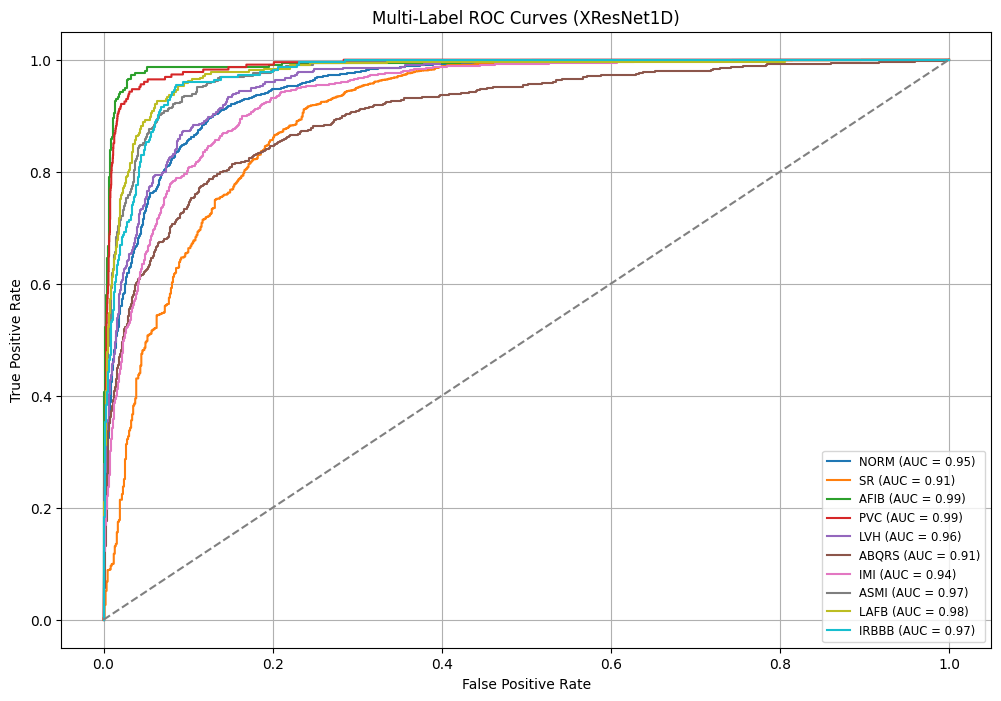

In [6]:
# Plot ROC Curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves (XResNet1D)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.show()
